In [1]:
# Needed for functions
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import time

# Import Qiskit Classes
from qiskit import *
from qiskit import IBMQ
from qiskit import transpile
from qiskit.providers.aer import AerSimulator, QasmSimulator, noise
from qiskit.providers.aer.extensions import *
from qiskit import quantum_info as qi
from qiskit.test.mock import FakeLima, FakeQuito, FakeBelem
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

# Import Visualization Tools
from qiskit.tools.visualization import plot_histogram as plth
from qiskit.visualization import plot_state_city, plot_state_hinton
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *


In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')


In [3]:
qcomp_B = provider.get_backend('ibmq_belem')
qcomp_B

<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
qcomp_Q = provider.get_backend('ibmq_quito')
qcomp_Q

<IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
qcomp_L = provider.get_backend('ibmq_lima')
qcomp_L

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
qcomp_sim_B = AerSimulator.from_backend(FakeBelem())
qcomp_sim_Q = AerSimulator.from_backend(FakeQuito())
qcomp_sim_L = AerSimulator.from_backend(FakeLima())


In [7]:
# Parametros libres globales
p_amp = 0.05
p_phs = 0.05
p_dprz = 0.05
shots = 8192

# Funcion para construir el circuito de codificación de 4 qubits para estados de Bell
def cod(creg = True):
    """
    Función que construye los pasos para realizar una codificación de 4
    qubits sobre un grafo de tipo T para obtener un estado de Bell entre
    sus extremos, usando un circuito construido mediante la teoría de MQNC.
    
    PARAMETROS:
        creg: Variable de tipo Booleano, para añadir o no un registro clásico.
        
    SALIDAS:
        qc: Circuito de la codificación.
    """
    qr = QuantumRegister(5, 'q')
    if creg:
        cr = ClassicalRegister(3, 'c')
        qc = QuantumCircuit(qr, cr)
    else:
        qc = QuantumCircuit(qr)

    qc.h([0, 1, 2, 3, 4])
    qc.cz([4, 1], [3, 2])
    qc.cz([1, 3], [0, 1])
    qc.h([1, 3])

    qc.barrier()

    qc.cx([1, 3],[0, 4])

    qc.barrier()

    qc.h([0, 2])

    return qc

# Función para ruido de Amplitud Damping
def amp_noise(p):
    """
    Funcion que sirve para crear un modelo ruidoso basado en Amplitud Damping
    y devolverlo al usuario, las operaciones sobre un solo qubit afectadas son
    rotación en z, raíz de X, rotación en 3 grados y el operador X, mientras
    que las operaciones sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_amp_1 = noise.amplitude_damping_error(p)
    noise_amp_2 = noise_amp_1.tensor(noise_amp_1)
    # Modelo Ruidoso de Amplitud Damping
    noisy_model_amp = noise.NoiseModel()
    noisy_model_amp.add_all_qubit_quantum_error(noise_amp_1,
                                                ['rz', 'sx', 'x', 'u3'])
    noisy_model_amp.add_all_qubit_quantum_error(noise_amp_2,
                                                ['cx', 'cz'])
    return noisy_model_amp

# Función para ruido de Depolarizing
def phs_noise(p):
    """
    Crea un modelo ruidoso basado en Phase Damping y devolverlo al usuario,
    las operaciones sobre un solo qubit afectadas son rotación en z, raíz
    de X, rotación en 3 grados y el operador X, mientras que las operaciones
    sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_phs_1 = noise.phase_damping_error(p)
    noise_phs_2 = noise_phs_1.tensor(noise_phs_1)
    # Modelo Ruidoso de Phase Damping
    noisy_model_phs = noise.NoiseModel()
    noisy_model_phs.add_all_qubit_quantum_error(noise_phs_1,
                                                ['rz', 'sx', 'x', 'u3'])
    noisy_model_phs.add_all_qubit_quantum_error(noise_phs_2,
                                                ['cx', 'cz'])
    return noisy_model_phs

# Función para ruido de Depolarizing
def dprz_noise(p):
    """
    Crea un modelo ruidoso basado en Depolarizing y devolverlo al usuario,
    las operaciones sobre un solo qubit afectadas son rotación en z, raíz
    de X, rotación en 3 grados y el operador X, mientras que las operaciones
    sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_dprz_1 = noise.depolarizing_error(p, 1)
    noise_dprz_2 = noise.depolarizing_error(p, 2)
    # Modelo Ruidoso de Depolarizing
    noisy_model_dprz = noise.NoiseModel()
    noisy_model_dprz.add_all_qubit_quantum_error(noise_dprz_1,
                                                 ['rz', 'sx', 'x', 'u3'])
    noisy_model_dprz.add_all_qubit_quantum_error(noise_dprz_2,
                                                 ['cx', 'cz'])
    return noisy_model_dprz

#Función para calcular la fidelidad
def fid(qc, qc_noise, noise_model, shots):
    """
    Calcular la fidelidad cuántica entre 2 circuitos, uno ideal y otro con
    ruido. Como el simulador de estados incluido en QISKit realiza n cantidad
    de corridas, es necesario calcular la fidelidad individual de cada una y
    después promediar el resultado para luego devolverlo al usuario.
    
    PARAMETROS:
        qc: Circuito sin ruido.
        qc_noise: Circuito con ruido.
        noise_model: Modelo del ruido.
        shots: Número de simulaciones.
    SALIDAS:
        f/j: Promedio de las fidelidades calculadas en cada corrida.
    """
    
    f = 0
    j = 0
    
    sv_qc = qc.copy()
    sv_qc.snapshot_statevector('final')
    sv = execute(sv_qc, QasmSimulator()).result().data(0)['snapshots']['statevector']['final'][0]

    #Circuitos simulados con el ruido clasico
    sv_qc_noise = qc_noise.copy()
    sv_qc_noise.snapshot_statevector('final')
    sv_noise = execute(sv_qc_noise, QasmSimulator(), shots=shots, noise_model=noise_model,
                       basis_gates=noise_model.basis_gates
                      ).result().data(0)['snapshots']['statevector']['final']
    for i in range (0, len(sv_noise)):
        if np.round(abs(sum([n ** 2 for n in sv_noise[i]])),4)==1.0000:
            j += 1
            f += qi.state_fidelity(sv, sv_noise[i])
            
    
    return f/j

#Función para calcular la matriz densidad usando tomografía
def tomo(qc, backend, qubits=[], cal_id = [], tomo_id = [], trans=True):
    """
    Calcular la matriz densidad de un circuito cuántico a partir de
    los resultados experimentales en forma de probabilidades, usando
    el método de tomografía cuántica con la subrutina de mitigación
    de errores en la medida mediante la calibración de un filtro
    construido a partir de los resultados en el error por cada posible
    combinación del registro cuántico.
    
    PARAMETROS:
        qc: Circuito cuántico.
        backend: Backend del dispositivo que se esté utilizando.
        qubits: Lista con los qubits relacionados a la medida
        cal_id: Lista con los marcadores en el backend de los circuitos
            para calibración.
        tomo_id: Lista con los marcadores en el backend de los circuitos
            para calcular la tomografía.
        transpile: Variable de tipo booleana para determinar si hay o no
            que transpilar el circuito. Especialmente útil para simular
            ruidos.
        noise: Lista con los modelos de ruido a aplicar durante la tomo-
            grafía.
    SALIDAS:
        P: 
            Matriz densidad obtenida sin filtrar el ruido.
        job_tomo.result().time_taken/60: 
            Tiempo de ejecución de los circuitos para la tomografía
            dentro del backend.
        P_mit: 
            Matriz densidad obtenida sin filtrar el ruido.
        (job_cal.result().time_taken+job_tomo.result().time_taken)/60: 
            Tiempo de ejecución de los circuitos para  la tomografía
            y calibración del filtro dentro del backend.
    """
        
    # Generate Circuits and Fitter for Calibration tomography.
    if trans:
        tqc_tomo = transpile(qc, backend)
    else:
        tqc_tomo = qc.copy()

    if len(qubits)==0:
        qst_tqc = state_tomography_circuits(tqc_tomo,
                                            tqc_tomo.qubits)
        meas_cal, state_labels = mc.complete_meas_cal(tqc_tomo.qubits)

    else:
        qst_tqc = state_tomography_circuits(tqc_tomo,
                                            qubits)
        meas_cal, state_labels = mc.complete_meas_cal(qubits)

    
    # Execute Job callibrated and not
    if len(cal_id)==0:
        if len(meas_cal)<100:
            job_cal = qiskit.execute(meas_cal, backend=backend, shots=shots)
        else:
            i=100
            job_cal = qiskit.execute(meas_cal[i-100:i], backend=backend, shots=shots)
            while True:
                i+=100
                if(i > len(meas_cal)):
                    print(i)
                    job = qiskit.execute(meas_cal[i-100:len(qst_tqc)],
                                         backend=backend,
                                         shots=shots).result()
                    
                    job_cal.result().results += job.results
                    job_cal.result().time_taken += job.time_taken
                    
                    break
                job = qiskit.execute(meas_cal[i-100:i],
                                     backend=backend,
                                     shots=shots).result()
                
                job_cal.result().results += job.results
                job_cal.result().time_taken += job.time_taken
                    
    else:
        job_cal = backend.retrieve_job(cal_id.pop(0))
        while len(cal_id)!=0:
            job = backend.retrieve_job(cal_id.pop(0)).result()
            
            job_cal.result().results += job.results
            job_cal.result().results += job.time_taken
            
            
    if len(tomo_id)==0:
        if len(qst_tqc)<100:
            job_tomo = qiskit.execute(qst_tqc, backend=backend, shots=shots)
        else:
            i=100
            job_tomo = qiskit.execute(qst_tqc[i-100:i], backend=backend, shots=shots)
            while True:
                i+=100
                if(i > len(qst_tqc)):
                    job = qiskit.execute(qst_tqc[i-100:len(qst_tqc)],
                                                   backend=backend,
                                                   shots=shots).result()
                    
                    job_tomo.result().results += job.results
                    job_tomo.result().time_taken += job.time_taken
                    
                    break
                job = qiskit.execute(qst_tqc[i-100:i],
                                               backend=backend,
                                               shots=shots).result()
                
                job_tomo.result().results += job.results
                job_tomo.result().time_taken += job.time_taken
                    
    else:
        job_tomo = backend.retrieve_job(tomo_id.pop(0))
        while len(tomo_id)!=0:
            job = backend.retrieve_job(tomo_id.pop(0)).result()

            job_tomo.result().results += job.results
            job_tomo.result().time_taken += job.time_taken
            
    meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels)
    tomo_tqc = StateTomographyFitter(job_tomo.result(), qst_tqc)

    # no correction
    P = tomo_tqc.fit(method='lstsq')

    # corrected data
    corr_tomo_tqc_res = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
    tomo_tqc_mit = StateTomographyFitter(corr_tomo_tqc_res, qst_tqc)
    P_mit = tomo_tqc_mit.fit(method='lstsq')
    
    return [P, job_tomo.result().time_taken/60, P_mit, (job_cal.result().time_taken+job_tomo.result().time_taken)/60]


Profundidad del Circuito:  7


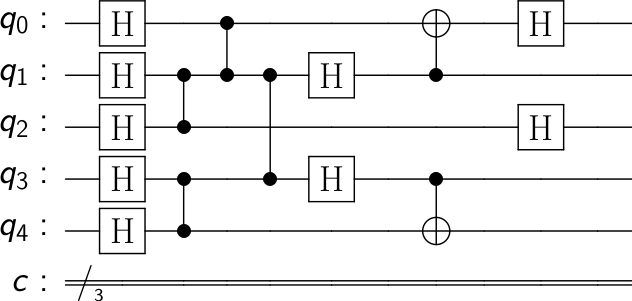

None

In [8]:
qc = cod(True
        )

display(qc.draw(output = 'latex', plot_barriers=False),
        print("Profundidad del Circuito: ", qc.depth()))


In [ ]:
Statevector&([ 3.53553391e-01+0.j, -3.14728961e-18+0.j,\\ &  3.53553391e-01+0.j,
             -3.14728961e-18+0.j,\\ &  6.73463194e-18+0.j,  8.90192164e-35+0.j,\\
           &   6.73463194e-18+0.j,  8.90192164e-35+0.j,\\ &  3.53553391e-01+0.j,
             -3.14728961e-18+0.j,\\ &  3.53553391e-01+0.j, -3.14728961e-18+0.j,\\
           &   6.73463194e-18+0.j,  8.90192164e-35+0.j,\\ &  6.73463194e-18+0.j,
              8.90192164e-35+0.j,\\ &  8.90192164e-35+0.j,  6.73463194e-18+0.j,\\
           &   8.90192164e-35+0.j,  6.73463194e-18+0.j,\\ & -3.14728961e-18+0.j,
              3.53553391e-01+0.j,\\ & -3.14728961e-18+0.j,  3.53553391e-01+0.j,\\
           &   8.90192164e-35+0.j,  6.73463194e-18+0.j,\\ &  8.90192164e-35+0.j,
              6.73463194e-18+0.j,\\ & -3.14728961e-18+0.j,  3.53553391e-01+0.j,\\
           &  -3.14728961e-18+0.j,  3.53553391e-01+0.j],\\ &
            dims=(2, 2, 2, 2, 2))

Statevector([ 3.53553391e-01+0.j, -3.14728961e-18+0.j,  3.53553391e-01+0.j,
             -3.14728961e-18+0.j,  6.73463194e-18+0.j,  8.90192164e-35+0.j,
              6.73463194e-18+0.j,  8.90192164e-35+0.j,  3.53553391e-01+0.j,
             -3.14728961e-18+0.j,  3.53553391e-01+0.j, -3.14728961e-18+0.j,
              6.73463194e-18+0.j,  8.90192164e-35+0.j,  6.73463194e-18+0.j,
              8.90192164e-35+0.j,  8.90192164e-35+0.j,  6.73463194e-18+0.j,
              8.90192164e-35+0.j,  6.73463194e-18+0.j, -3.14728961e-18+0.j,
              3.53553391e-01+0.j, -3.14728961e-18+0.j,  3.53553391e-01+0.j,
              8.90192164e-35+0.j,  6.73463194e-18+0.j,  8.90192164e-35+0.j,
              6.73463194e-18+0.j, -3.14728961e-18+0.j,  3.53553391e-01+0.j,
             -3.14728961e-18+0.j,  3.53553391e-01+0.j],
            dims=(2, 2, 2, 2, 2))


None

C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\visualization\state_visualization.py:705: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


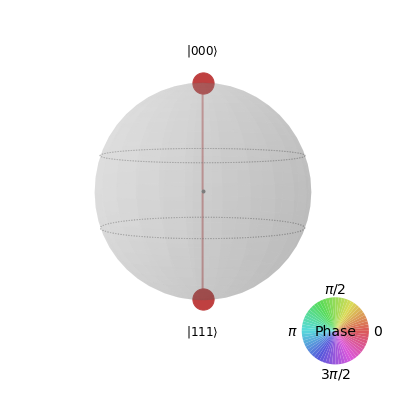

In [9]:
svs = BasicAer.get_backend('statevector_simulator')
qc_svs = execute(qc, svs).result()
qc_P  = qi.DensityMatrix(qc_svs.get_statevector(qc))
qc_sv = qi.Statevector.from_instruction(qc)
display(print(qc_sv),
        #psi.draw(output='qsphere'),
        qi.partial_trace(qc_P, [1, 3]).draw(output='qsphere'),
        # plot_state_city(Ro_psi),
        #plot_state_hinton(psi)
       )

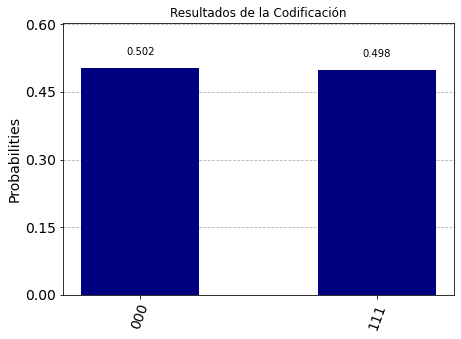

In [10]:
qc_meas = qc.copy()
qc_meas.measure([0, 2, 4], [0, 1, 2])
sim = Aer.get_backend('qasm_simulator')
counts = execute(qc_meas, backend = sim, shots = shots).result().get_counts()
plth(counts,
     title='Resultados de la Codificación',
     color=[
           'navy'
          ],
     figsize=(7, 5)
)

In [23]:
print(counts)
for i in counts:
    print(i, ': ',counts[i], '/',counts[i]/shots)

{'111': 4083, '000': 4109}
111 :  4083 / 0.4984130859375
000 :  4109 / 0.5015869140625


In [12]:
# Transpile the circuit for the sistems basis gates
tqc_sim_b = transpile(qc, qcomp_sim_B)
tqc_sim_b_sv = qi.Statevector.from_instruction(tqc_sim_b)
tqc_sim_b_meas = tqc_sim_b.copy()
tqc_sim_b_meas.measure([0, 2, 4], [0, 1, 2])

tqc_sim_q = transpile(qc, qcomp_sim_Q)
tqc_sim_q_sv = qi.Statevector.from_instruction(tqc_sim_q)
tqc_sim_q_meas = tqc_sim_q.copy()
tqc_sim_q_meas.measure([0, 2, 4], [0, 1, 2])

tqc_sim_l = transpile(qc, qcomp_sim_L)
tqc_sim_l_sv = qi.Statevector.from_instruction(tqc_sim_l)
tqc_sim_l_meas = tqc_sim_l.copy()
tqc_sim_l_meas.measure([0, 2, 4], [0, 1, 2])

# Transpile the circuit for the sistems basis gates using the real object
tqc_b = transpile(qc, qcomp_B)
tqc_b_sv = qi.Statevector.from_instruction(tqc_b)
tqc_b_meas = tqc_b.copy()
tqc_b_meas.measure([0, 2, 4], [0, 1, 2])

tqc_q = transpile(qc, qcomp_Q)
tqc_q_sv = qi.Statevector.from_instruction(tqc_q)
tqc_q_meas = tqc_q.copy()
tqc_q_meas.measure([0, 2, 4], [0, 1, 2])

tqc_l = transpile(qc, qcomp_L)
tqc_l_sv = qi.Statevector.from_instruction(tqc_l)
tqc_l_meas = tqc_l.copy()
tqc_l_meas.measure([0, 2, 4], [0, 1, 2])


Vector de estado del Circuito usando el sistema real:
  Statevector([ 3.53553391e-01+1.94289029e-16j,
             -2.46519033e-32+9.81307787e-17j,
              3.53553391e-01+1.94289029e-16j,
             -2.46519033e-32+9.81307787e-17j,
              0.00000000e+00+1.17756934e-16j,
              9.81307787e-18+7.85046229e-17j,
              0.00000000e+00+1.17756934e-16j,
              9.81307787e-18+7.85046229e-17j,
              3.53553391e-01+0.00000000e+00j,
              9.81307787e-18+9.81307787e-17j,
              3.53553391e-01+0.00000000e+00j,
              9.81307787e-18+9.81307787e-17j,
              0.00000000e+00+7.85046229e-17j,
             -1.84889275e-32+5.88784672e-17j,
              0.00000000e+00+7.85046229e-17j,
             -1.84889275e-32+5.88784672e-17j,
             -4.90653893e-18+7.85046229e-17j,
              0.00000000e+00+7.85046229e-17j,
             -4.90653893e-18+7.85046229e-17j,
              0.00000000e+00+7.85046229e-17j,
              4.90653893

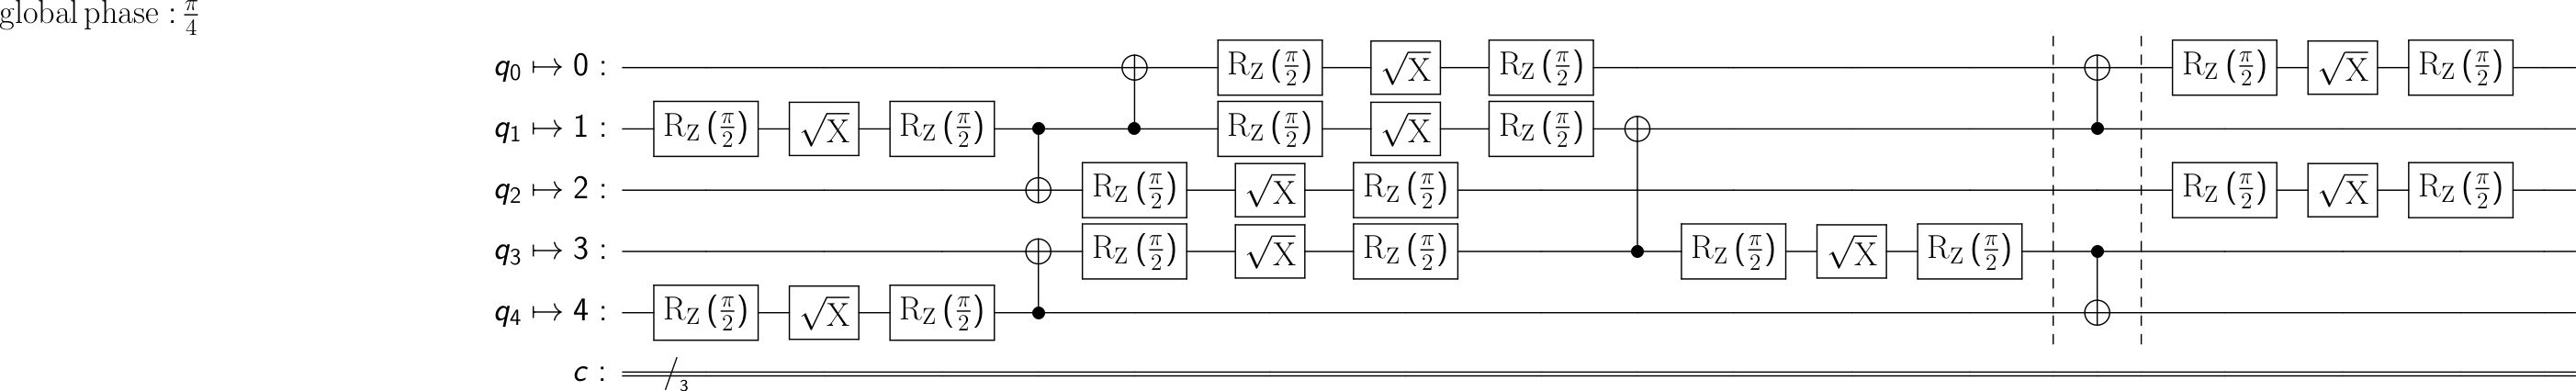

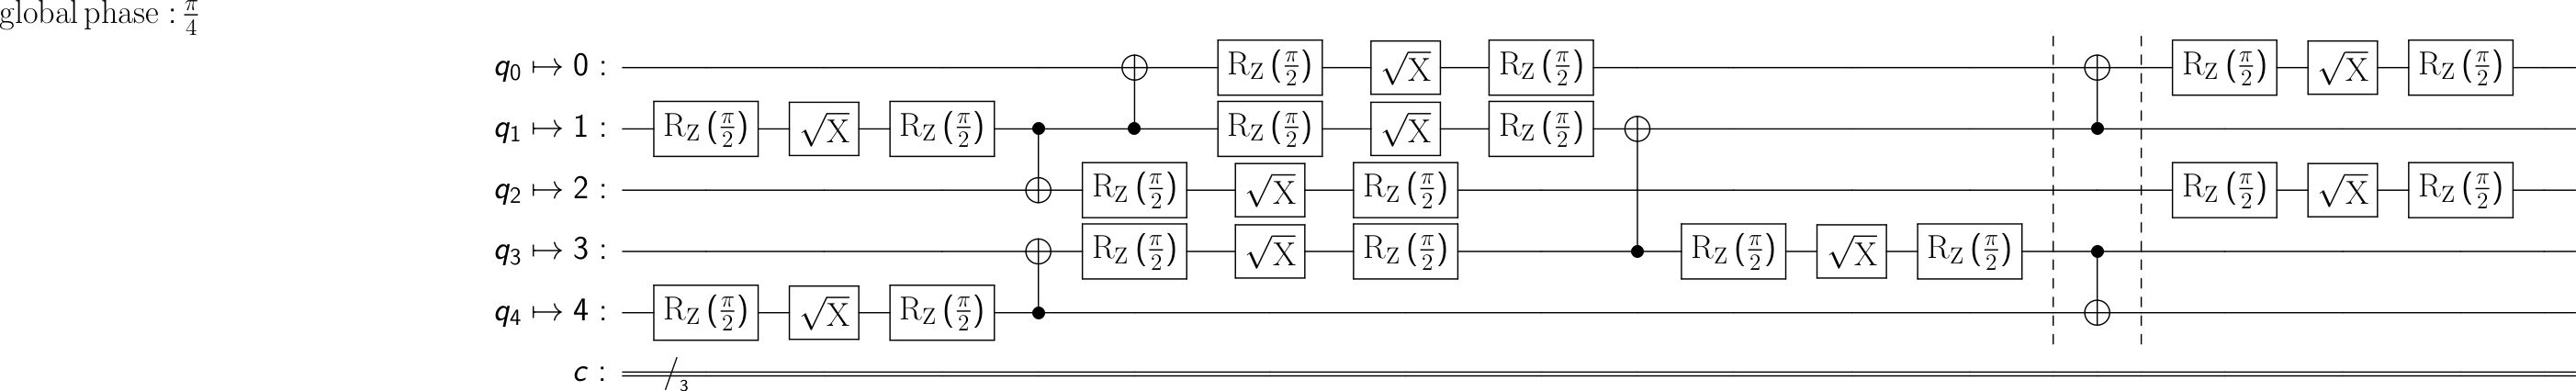

None

None

None

None

In [13]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_b.draw('latex'),
        tqc_sim_b.draw('latex'),
        print("Vector de estado del Circuito usando el sistema real:\n ", tqc_b_sv),
        print("\n\nVector de estado del Circuito usando el sistema real:\n ", tqc_sim_b_sv),
        print("\n\nProfundidad del Circuito usando el sistema real:\n ", tqc_b.depth()),
        print("\n\nProfundidad del Circuito usando el modelo de prueba:\n ", tqc_sim_b.depth()))


Vector de estado del Circuito usando el sistema real:
  Statevector([ 3.53553391e-01+1.94289029e-16j,
             -2.46519033e-32+9.81307787e-17j,
              3.53553391e-01+1.94289029e-16j,
             -2.46519033e-32+9.81307787e-17j,
              0.00000000e+00+1.17756934e-16j,
              9.81307787e-18+7.85046229e-17j,
              0.00000000e+00+1.17756934e-16j,
              9.81307787e-18+7.85046229e-17j,
              3.53553391e-01+0.00000000e+00j,
              9.81307787e-18+9.81307787e-17j,
              3.53553391e-01+0.00000000e+00j,
              9.81307787e-18+9.81307787e-17j,
              0.00000000e+00+7.85046229e-17j,
             -1.84889275e-32+5.88784672e-17j,
              0.00000000e+00+7.85046229e-17j,
             -1.84889275e-32+5.88784672e-17j,
             -4.90653893e-18+7.85046229e-17j,
              0.00000000e+00+7.85046229e-17j,
             -4.90653893e-18+7.85046229e-17j,
              0.00000000e+00+7.85046229e-17j,
              4.90653893

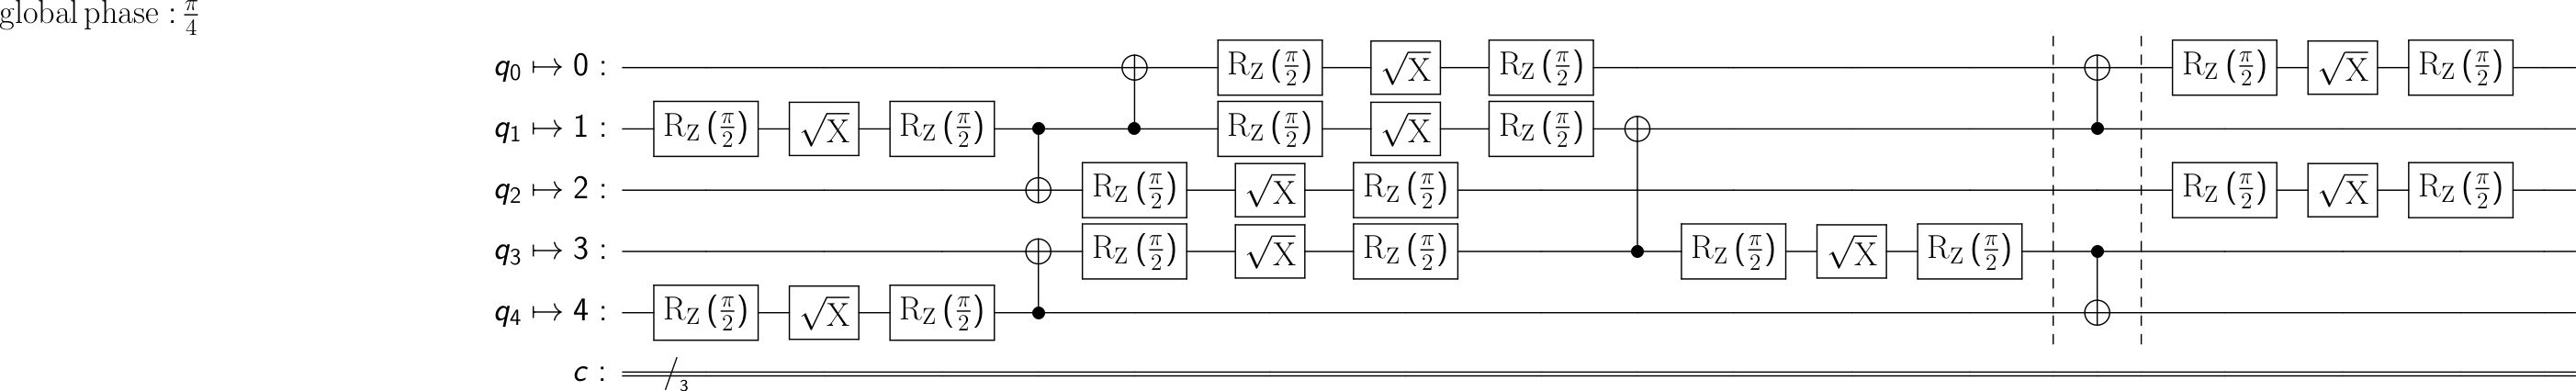

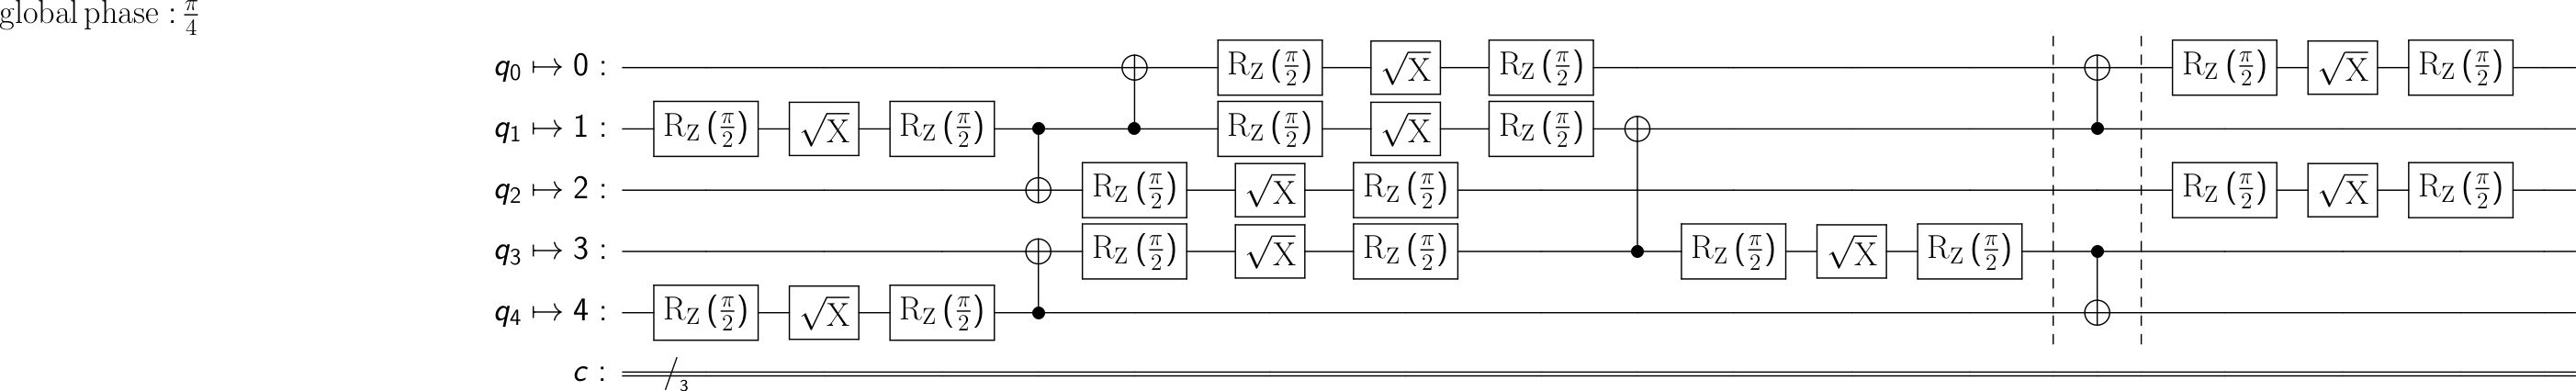

None

None

None

None

In [14]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_b.draw('latex'),
        tqc_sim_b.draw('latex'),
        print("Vector de estado del Circuito usando el sistema real:\n ", tqc_q_sv),
        print("\n\nVector de estado del Circuito usando el sistema real:\n ", tqc_sim_q_sv),
        print("\n\nProfundidad del Circuito usando el sistema real:\n ", tqc_q.depth()),
        print("\n\nProfundidad del Circuito usando el modelo de prueba:\n ", tqc_sim_q.depth()))


Vector de estado del Circuito usando el sistema real:
  Statevector([ 3.53553391e-01+1.94289029e-16j,
             -2.46519033e-32+9.81307787e-17j,
              3.53553391e-01+1.94289029e-16j,
             -2.46519033e-32+9.81307787e-17j,
              0.00000000e+00+1.17756934e-16j,
              9.81307787e-18+7.85046229e-17j,
              0.00000000e+00+1.17756934e-16j,
              9.81307787e-18+7.85046229e-17j,
              3.53553391e-01+0.00000000e+00j,
              9.81307787e-18+9.81307787e-17j,
              3.53553391e-01+0.00000000e+00j,
              9.81307787e-18+9.81307787e-17j,
              0.00000000e+00+7.85046229e-17j,
             -1.84889275e-32+5.88784672e-17j,
              0.00000000e+00+7.85046229e-17j,
             -1.84889275e-32+5.88784672e-17j,
             -4.90653893e-18+7.85046229e-17j,
              0.00000000e+00+7.85046229e-17j,
             -4.90653893e-18+7.85046229e-17j,
              0.00000000e+00+7.85046229e-17j,
              4.90653893

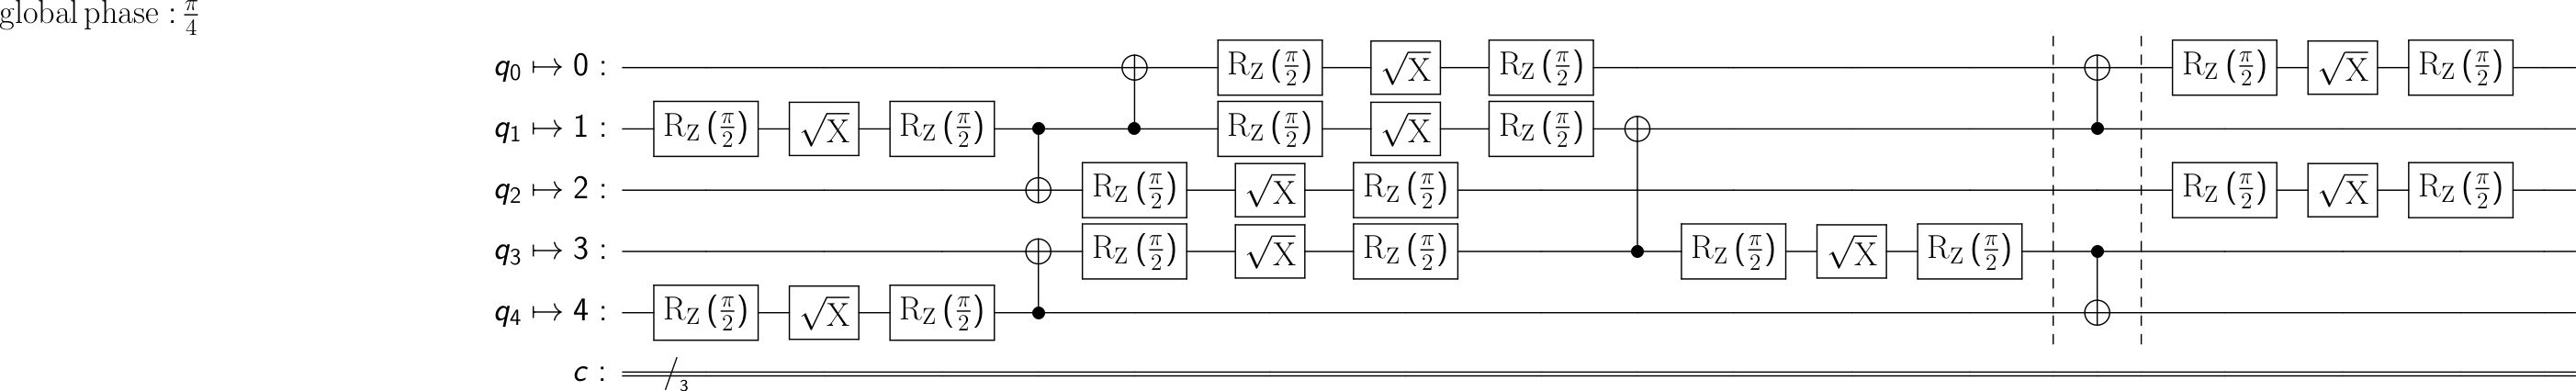

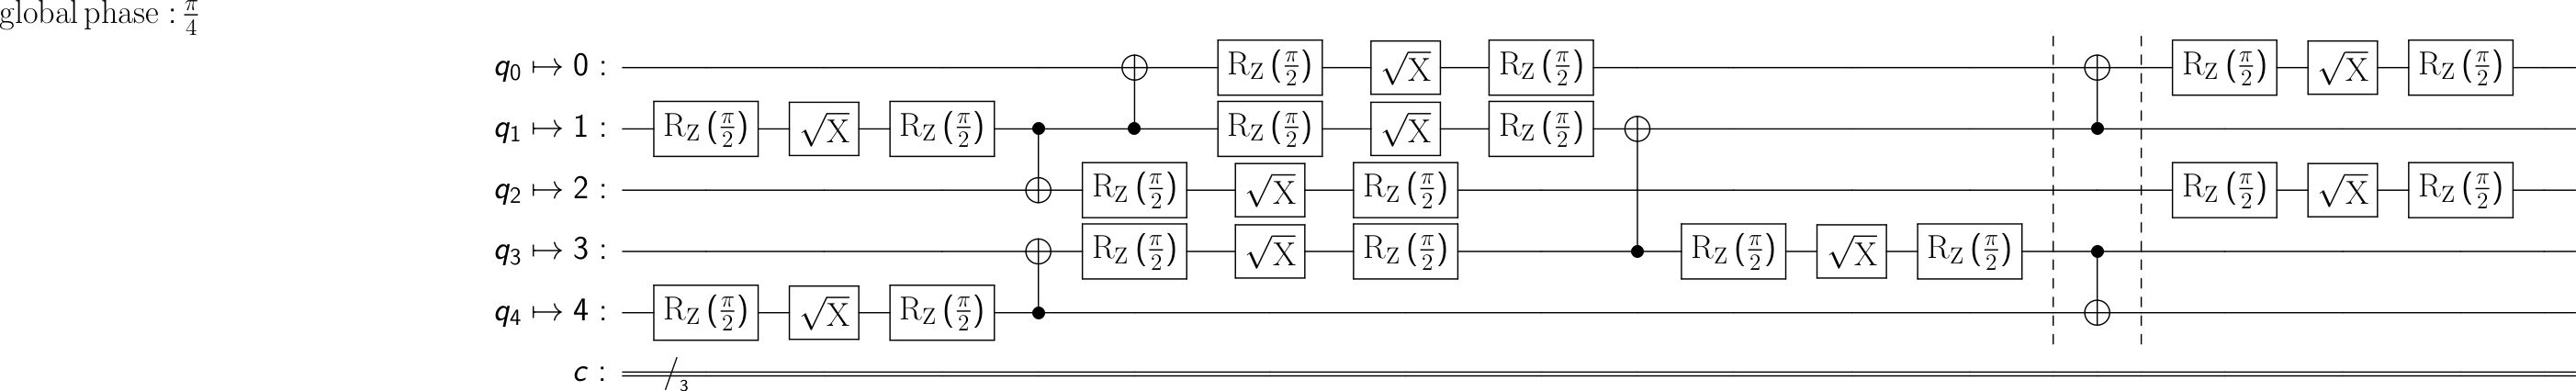

None

None

None

None

In [15]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_b.draw('latex'),
        tqc_sim_b.draw('latex'),
        print("Vector de estado del Circuito usando el sistema real:\n ", tqc_l_sv),
        print("\n\nVector de estado del Circuito usando el sistema real:\n ", tqc_sim_l_sv),
        print("\n\nProfundidad del Circuito usando el sistema real:\n ", tqc_l.depth()),
        print("\n\nProfundidad del Circuito usando el modelo de prueba:\n ", tqc_sim_l.depth()))


In [218]:
#qiskit.execute(tqc_b_meas, backend=qcomp_B, shots=shots)
#qiskit.execute(tqc_q_meas, backend=qcomp_Q, shots=shots)
#qiskit.execute(tqc_l_meas, backend=qcomp_L, shots=shots)


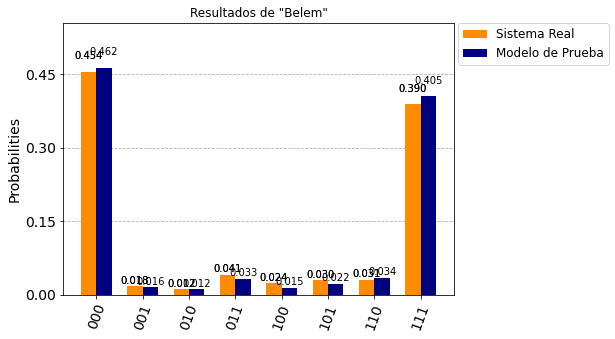

In [13]:
# Execute circuit on Belen system
counts_b = qcomp_B.retrieve_job('61a9fa54d73dea3667372d56').result().get_counts()

# Execute noisy simulation on dummys
counts_sim_b = qcomp_sim_B.run(tqc_sim_b_meas, shots=shots).result().get_counts(tqc_sim_b_meas)

plth(
    [counts_b,
     counts_sim_b
    ],
    legend=['Sistema Real',
            'Modelo de Prueba'
           ],
    title='Resultados de "Belem"',
    color=['darkorange',
           'navy'
          ],
    figsize=(7, 5)
)

In [24]:
print('Cuentas de la codificación emulada: \n', counts_b)
for i in counts_b:
    print(i, ': ',counts_b[i], '/',counts_b[i]/shots)
print('\nCuentas de la codificación simulada: \n', counts_sim_b)
for i in counts_sim_b:
    print(i, ': ',counts_sim_b[i], '/',counts_sim_b[i]/shots)
    

Cuentas de la codificación emulada: 
 {'000': 3719, '001': 145, '010': 98, '011': 337, '100': 193, '101': 246, '110': 256, '111': 3198}
000 :  3719 / 0.4539794921875
001 :  145 / 0.0177001953125
010 :  98 / 0.011962890625
011 :  337 / 0.0411376953125
100 :  193 / 0.0235595703125
101 :  246 / 0.030029296875
110 :  256 / 0.03125
111 :  3198 / 0.390380859375

Cuentas de la codificación simulada: 
 {'111': 3320, '000': 3785, '110': 281, '101': 184, '100': 123, '010': 95, '001': 130, '011': 274}
111 :  3320 / 0.4052734375
000 :  3785 / 0.4620361328125
110 :  281 / 0.0343017578125
101 :  184 / 0.0224609375
100 :  123 / 0.0150146484375
010 :  95 / 0.0115966796875
001 :  130 / 0.015869140625
011 :  274 / 0.033447265625


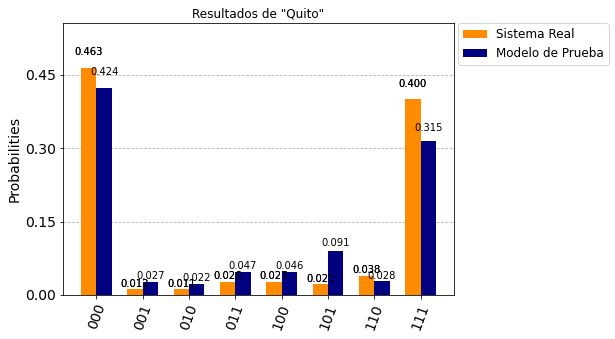

In [15]:
# Execute circuit on Belen system
counts_q = qcomp_Q.retrieve_job('61aceeebd73dea8dd23736b5').result().get_counts()

# Execute noisy simulation on dummys
counts_sim_q = qcomp_sim_Q.run(tqc_sim_q_meas, shots=shots).result().get_counts(tqc_sim_q_meas)

plth(
    [counts_q,
     counts_sim_q,
    ],
    legend=['Sistema Real',
            'Modelo de Prueba'
           ],
    title='Resultados de "Quito"',
    color=['darkorange',
           'navy'
          ],
    figsize=(7, 5)
)

In [25]:
print('Cuentas de la codificación emulada: \n', counts_q)
for i in counts_q:
    print(i, ': ',counts_q[i], '/',counts_q[i]/shots)
print('\nCuentas de la codificación simulada: \n', counts_sim_q)
for i in counts_sim_q:
    print(i, ': ',counts_sim_q[i], '/',counts_sim_q[i]/shots)
    

Cuentas de la codificación emulada: 
 {'000': 3794, '001': 98, '010': 94, '011': 217, '100': 218, '101': 176, '110': 315, '111': 3280}
000 :  3794 / 0.463134765625
001 :  98 / 0.011962890625
010 :  94 / 0.011474609375
011 :  217 / 0.0264892578125
100 :  218 / 0.026611328125
101 :  176 / 0.021484375
110 :  315 / 0.0384521484375
111 :  3280 / 0.400390625

Cuentas de la codificación simulada: 
 {'111': 2581, '000': 3475, '100': 377, '101': 742, '001': 218, '110': 228, '011': 387, '010': 184}
111 :  2581 / 0.3150634765625
000 :  3475 / 0.4241943359375
100 :  377 / 0.0460205078125
101 :  742 / 0.090576171875
001 :  218 / 0.026611328125
110 :  228 / 0.02783203125
011 :  387 / 0.0472412109375
010 :  184 / 0.0224609375


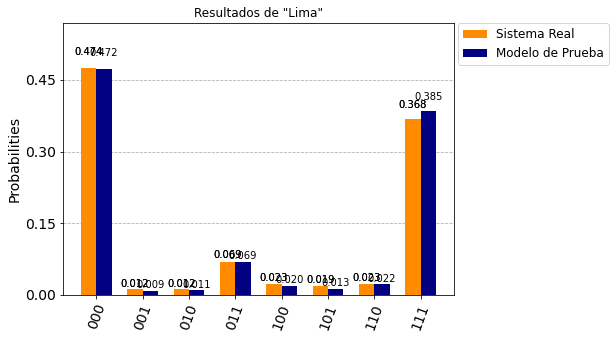

In [17]:
# Execute circuit on Belen system
counts_l = qcomp_L.retrieve_job('61aceeedbf880353a63098c8').result().get_counts()

# Execute noisy simulation on dummys
counts_sim_l = qcomp_sim_L.run(tqc_sim_l_meas, shots=shots).result().get_counts(tqc_sim_l_meas)

plth(
    [counts_l,
     counts_sim_l,
    ],
    legend=['Sistema Real',
            'Modelo de Prueba'
           ],
    title='Resultados de "Lima"',
    color=['darkorange',
           'navy'
          ],
    figsize=(7, 5)
)

In [26]:
print('Cuentas de la codificación emulada: \n', counts_l)
for i in counts_l:
    print(i, ': ',counts_l[i], '/',counts_l[i]/shots)
print('\nCuentas de la codificación simulada: \n', counts_sim_l)
for i in counts_sim_l:
    print(i, ': ',counts_sim_l[i], '/',counts_sim_l[i]/shots)


Cuentas de la codificación emulada: 
 {'000': 3880, '001': 95, '010': 100, '011': 566, '100': 190, '101': 156, '110': 189, '111': 3016}
000 :  3880 / 0.4736328125
001 :  95 / 0.0115966796875
010 :  100 / 0.01220703125
011 :  566 / 0.069091796875
100 :  190 / 0.023193359375
101 :  156 / 0.01904296875
110 :  189 / 0.0230712890625
111 :  3016 / 0.3681640625

Cuentas de la codificación simulada: 
 {'000': 3868, '111': 3150, '011': 562, '001': 75, '110': 182, '010': 88, '100': 160, '101': 107}
000 :  3868 / 0.47216796875
111 :  3150 / 0.384521484375
011 :  562 / 0.068603515625
001 :  75 / 0.0091552734375
110 :  182 / 0.022216796875
010 :  88 / 0.0107421875
100 :  160 / 0.01953125
101 :  107 / 0.0130615234375


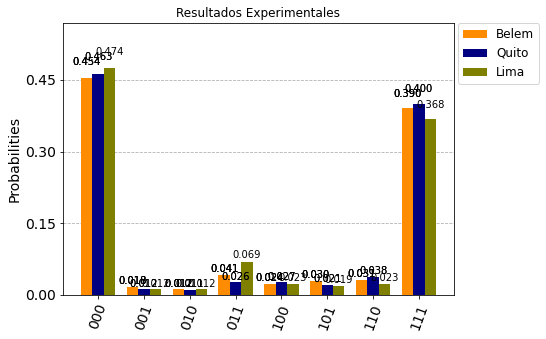

In [19]:
plth(
    [counts_b,
     counts_q,
     counts_l
    ],
    legend=['Belem',
            'Quito',
            'Lima'
           ],
    title='Resultados Experimentales',
    color=['darkorange',
           'navy',
           'olive'
           ],
    figsize=(7, 5)
)

In [28]:
for i in range(len(counts_b)):
    print('{0:03b}'.format(i), ' ',counts_b['{0:03b}'.format(i)], '/',
          round(counts_b['{0:03b}'.format(i)]/shots, 5), ' ',
          counts_sim_b['{0:03b}'.format(i)], '/',
          round(counts_sim_b['{0:03b}'.format(i)]/shots, 5), ' ',
          counts_q['{0:03b}'.format(i)], '/',
          round(counts_q['{0:03b}'.format(i)]/shots, 5), ' ',
          counts_sim_q['{0:03b}'.format(i)], '/',
          round(counts_sim_q['{0:03b}'.format(i)]/shots, 5), ' ',
          counts_l['{0:03b}'.format(i)], '/',
          round(counts_l['{0:03b}'.format(i)]/shots, 5), ' ',
          counts_sim_l['{0:03b}'.format(i)], '/',
          round(counts_sim_l['{0:03b}'.format(i)]/shots, 5)
         )

000   3719 / 0.45398   3785 / 0.46204   3794 / 0.46313   3475 / 0.42419   3880 / 0.47363   3868 / 0.47217
001   145 / 0.0177   130 / 0.01587   98 / 0.01196   218 / 0.02661   95 / 0.0116   75 / 0.00916
010   98 / 0.01196   95 / 0.0116   94 / 0.01147   184 / 0.02246   100 / 0.01221   88 / 0.01074
011   337 / 0.04114   274 / 0.03345   217 / 0.02649   387 / 0.04724   566 / 0.06909   562 / 0.0686
100   193 / 0.02356   123 / 0.01501   218 / 0.02661   377 / 0.04602   190 / 0.02319   160 / 0.01953
101   246 / 0.03003   184 / 0.02246   176 / 0.02148   742 / 0.09058   156 / 0.01904   107 / 0.01306
110   256 / 0.03125   281 / 0.0343   315 / 0.03845   228 / 0.02783   189 / 0.02307   182 / 0.02222
111   3198 / 0.39038   3320 / 0.40527   3280 / 0.40039   2581 / 0.31506   3016 / 0.36816   3150 / 0.38452


In [271]:
t = time.time()

cal_id = ['61acefdef15b03e4059a232d'

]

tomo_id = ['61ad026aa880fe5893645b8f',
           '61ad0272f15b0375879a2364',
           '61ad0508f15b031c4a9a236a'
          ]

P = tomo(qc=cod(False),
         backend=qcomp_B,
         qubits=[0, 1, 2, 3, 4],
         cal_id=cal_id,
         tomo_id=tomo_id) 

F_b = qi.state_fidelity(P[0], tqc_b_sv)
F_b_mit = qi.state_fidelity(P[2], tqc_b_sv)
print('Fidelidad en "Belem"(s/ corrección): F = {:.5f}'.format(F_b))
print('                    (c/ corrección): F = {:.5f}'.format(F_b_mit))
print('\n\nTiempo de ejecución (s/ corrección): t = {:.5f}'.format(P[1]))
print('                    (c/ corrección): t = {:.5f}'.format(P[3]))
print('\n\nTiempo transcurrido: t = {:.5f}'.format(time.time() - t))


Fidelidad en "Belem"(s/ corrección): F = 0.54370
                    (c/ corrección): F = 0.72890


Tiempo de ejecución (s/ corrección): t = 9.31069
                    (c/ corrección): t = 10.56693


Tiempo transcurrido: t = 33.67888


In [256]:
t = time.time()

cal_id = ['61acf12fa880fe6334645b5c'

]

tomo_id = ['61ad06742e6f453df19c7ee0',
           '61ad067fbd9cd26e6c56ae7f',
           '61ad09fef15b03190b9a237c'   
]

P = tomo(qc=cod(False),
         backend=qcomp_Q,
         qubits=[0, 1, 2, 3, 4],
         cal_id=cal_id,
         tomo_id=tomo_id) 

F_q = qi.state_fidelity(P[0], tqc_q_sv)
F_q_mit = qi.state_fidelity(P[2], tqc_q_sv)
print('Fidelidad en "Quito" (s/ corrección): F = {:.5f}'.format(F_q))
print('                     (c/ corrección): F = {:.5f}'.format(F_q_mit))
print('\n\nTiempo de ejecución (s/ corrección): t = {:.5f}'.format(P[1]))
print('                    (c/ corrección): t = {:.5f}'.format(P[3]))
print('\n\nTiempo transcurrido: t = {:.5f}'.format(time.time() - t))


Fidelidad en "Quitp" (s/ corrección): F = 0.73109
                     (c/ corrección): F = 0.87404


Tiempo de ejecución (s/ corrección): t = 9.29411
                        (c/ corrección): t = 10.54347


Tiempo transcurrido: t = 32.20916


In [257]:
t = time.time()

cal_id = ['61acfda3d73dea23923736ef'

]

tomo_id = ['61acfda9f15b0398e89a2358',
           '61acfdbddcbe23239f1942bb',
           '61ad0151bd9cd2501c56ae6b'
    
]

P = tomo(qc=cod(False),
         backend=qcomp_L,
         qubits=[0, 1, 2, 3, 4],
         cal_id=cal_id,
         tomo_id=tomo_id) 

F_l = qi.state_fidelity(P[0], tqc_l_sv)
F_l_mit = qi.state_fidelity(P[2], tqc_l_sv)
print('Fidelidad en "Lima" (s/ corrección): F = {:.5f}'.format(F_l))
print('                    (c/ corrección): F = {:.5f}'.format(F_l_mit))
print('\n\nTiempo de ejecución (s/ corrección): t = {:.5f}'.format(P[1]))
print('                    (c/ corrección): t = {:.5f}'.format(P[3]))
print('\n\nTiempo transcurrido: t = {:.5f}'.format(time.time() - t))


Fidelidad en "Lima" (s/ corrección): F = 0.70844
                    (c/ corrección): F = 0.89265


Tiempo de ejecución (s/ corrección): t = 9.29446
                        (c/ corrección): t = 10.54668


Tiempo transcurrido: t = 41.57273


In [272]:
t = time.time()

P_sim = tomo(qc=cod(False),
              backend=qcomp_sim_B,
              qubits=[0, 1, 2, 3, 4]) 

F_sim_b = qi.state_fidelity(P_sim[0], tqc_sim_b_sv)
F_sim_b_mit = qi.state_fidelity(P_sim[2], tqc_sim_b_sv)
print('Fidelidad en el Modelo de prueba de "Belem" (s/ corrección): F = {:.5f}'.format(F_sim_b))
print('                                            (c/ corrección): F = {:.5f}'.format(F_sim_b_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Belem" (s/ corrección): F = 0.77539
                                            (c/ corrección): F = 0.90353


Tiempo de ejecución [minutos] (s/ corrección): t = 0.30438
                              (c/ corrección): t = 0.35718


Tiempo transcurrido [segundos] : t = 41.12096


In [258]:
t = time.time()

P_sim = tomo(qc=cod(False),
              backend=qcomp_sim_Q,
              qubits=[0, 1, 2, 3, 4]) 

F_sim_q = qi.state_fidelity(P_sim[0], tqc_sim_q_sv)
F_sim_q_mit = qi.state_fidelity(P_sim[2], tqc_sim_q_sv)
print('Fidelidad en el Modelo de prueba de "Quito" (s/ corrección): F = {:.5f}'.format(F_sim_q))
print('                                            (c/ corrección): F = {:.5f}'.format(F_sim_q_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Quito" (s/ corrección): F = 0.58278
                                            (c/ corrección): F = 0.79032


Tiempo de ejecución [minutos] (s/ corrección): t = 0.24000
                                  (c/ corrección): t = 0.30261


Tiempo transcurrido [segundos] : t = 35.13782


In [259]:
t = time.time()

P_sim = tomo(qc=cod(False),
              qcomp=qcomp_sim_L,
              qubits=[0, 1, 2, 3, 4]) 

F_sim_l = qi.state_fidelity(P_sim[0], tqc_sim_l_sv)
F_sim_l_mit = qi.state_fidelity(P_sim[2], tqc_sim_l_sv)
print('Fidelidad en el Modelo de prueba de "Lima" (s/ corrección): F = {:.5f}'.format(F_sim_l))
print('                                           (c/ corrección): F = {:.5f}'.format(F_sim_l_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Lima" (s/ corrección): F = 0.75016
                                           (c/ corrección): F = 0.91399


Tiempo de ejecución [minutos] (s/ corrección): t = 0.21224
                                  (c/ corrección): t = 0.24287


Tiempo transcurrido [segundos] : t = 34.60891


In [20]:
# RUIDOS Clásicos

noisy_amp = amp_noise(p=p_amp)

noisy_phs = phs_noise(p=p_phs)

noisy_dprz = dprz_noise(p=p_dprz)

print(noisy_amp)
print(noisy_phs)
print(noisy_dprz)


NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['rz', 'x', 'cz', 'sx', 'cx', 'u3']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['rz', 'x', 'cz', 'sx', 'cx', 'u3']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['rz', 'x', 'cz', 'sx', 'cx', 'u3']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']


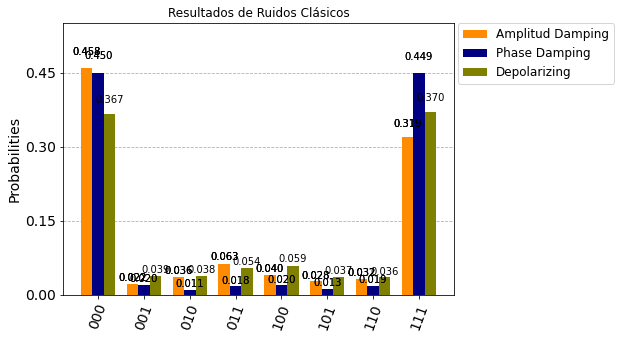

In [21]:
# Simular el Ruido de Amplitud Damping
sim_noise_amp = AerSimulator(noise_model=noisy_amp)
sim_noise_phs = AerSimulator(noise_model=noisy_phs)
sim_noise_dprz = AerSimulator(noise_model=noisy_dprz)

tqc_noise_amp = transpile(qc, sim_noise_amp)
tqc_noise_phs = transpile(qc, sim_noise_phs)
tqc_noise_dprz = transpile(qc, sim_noise_dprz)

tqc_noise_amp_meas = tqc_noise_amp.copy()
tqc_noise_amp_meas.measure([0, 2, 4], [0, 1, 2])
result_noise_amp = sim_noise_amp.run(tqc_noise_amp_meas, shots=shots).result()

tqc_noise_phs_meas = tqc_noise_phs.copy()
tqc_noise_phs_meas.measure([0, 2, 4], [0, 1, 2])
result_noise_phs = sim_noise_phs.run(tqc_noise_phs_meas, shots=shots).result()

tqc_noise_dprz_meas = tqc_noise_dprz.copy()
tqc_noise_dprz_meas.measure([0, 2, 4], [0, 1, 2])
result_noise_dprz = sim_noise_dprz.run(tqc_noise_dprz_meas, shots=shots).result()

counts_noise_amp = result_noise_amp.get_counts(tqc_noise_amp_meas)
counts_noise_phs = result_noise_phs.get_counts(tqc_noise_phs_meas)
counts_noise_dprz = result_noise_dprz.get_counts(tqc_noise_dprz_meas)

plth(
    [counts_noise_amp,
     counts_noise_phs,
     counts_noise_dprz
    ],
    legend=['Amplitud Damping',
            'Phase Damping',
            'Depolarizing'
           ],
    title='Resultados de Ruidos Clásicos',
    color=['darkorange',
           'navy',
           'olive'
          ],
    figsize=(7, 5)
)

In [27]:
print('Cuentas de la codificación con Amp Dmp: \n', counts_noise_amp)
for i in counts_noise_amp:
    print(i, ': ',counts_noise_amp[i], '/',counts_noise_amp[i]/shots)
print('\nCuentas de la codificación con Phs Dmp: \n', counts_noise_phs)
for i in counts_noise_phs:
    print(i, ': ',counts_noise_phs[i], '/',counts_noise_phs[i]/shots)
print('\nCuentas de la codificación con Dprz: \n', counts_noise_dprz)
for i in counts_noise_dprz:
    print(i, ': ',counts_noise_dprz[i], '/',counts_noise_dprz[i]/shots)


Cuentas de la codificación con Amp Dmp: 
 {'000': 3756, '011': 516, '101': 229, '111': 2616, '110': 262, '010': 299, '001': 183, '100': 331}
000 :  3756 / 0.45849609375
011 :  516 / 0.06298828125
101 :  229 / 0.0279541015625
111 :  2616 / 0.3193359375
110 :  262 / 0.031982421875
010 :  299 / 0.0364990234375
001 :  183 / 0.0223388671875
100 :  331 / 0.0404052734375

Cuentas de la codificación con Phs Dmp: 
 {'111': 3679, '000': 3689, '110': 157, '001': 167, '100': 164, '101': 103, '011': 144, '010': 89}
111 :  3679 / 0.4490966796875
000 :  3689 / 0.4503173828125
110 :  157 / 0.0191650390625
001 :  167 / 0.0203857421875
100 :  164 / 0.02001953125
101 :  103 / 0.0125732421875
011 :  144 / 0.017578125
010 :  89 / 0.0108642578125

Cuentas de la codificación con Dprz: 
 {'111': 3033, '000': 3007, '001': 319, '110': 291, '100': 487, '010': 311, '011': 444, '101': 300}
111 :  3033 / 0.3702392578125
000 :  3007 / 0.3670654296875
001 :  319 / 0.0389404296875
110 :  291 / 0.0355224609375
100 :  4

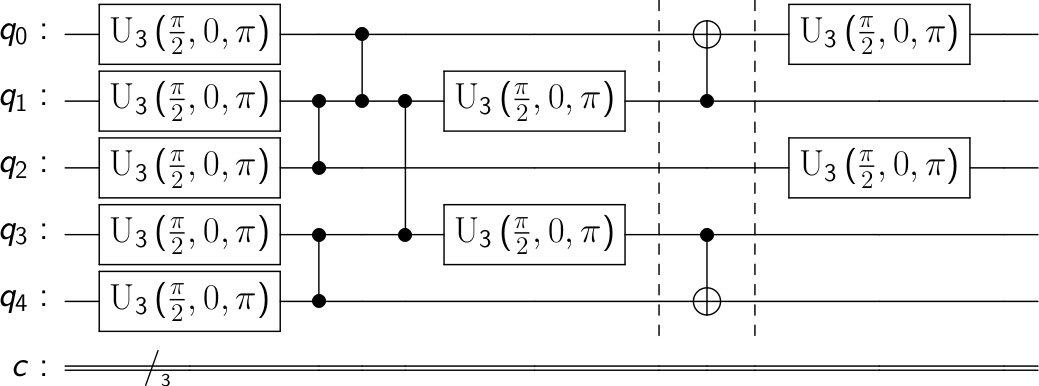

In [262]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_noise_amp.draw('latex')

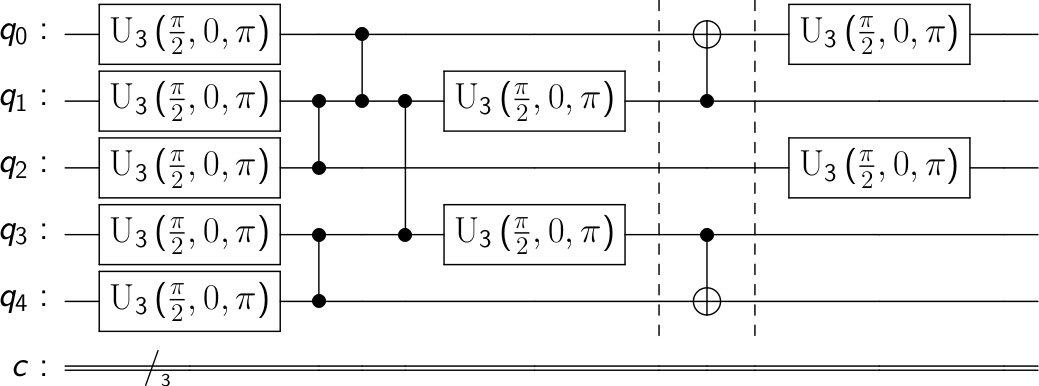

In [263]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_noise_phs.draw('latex')

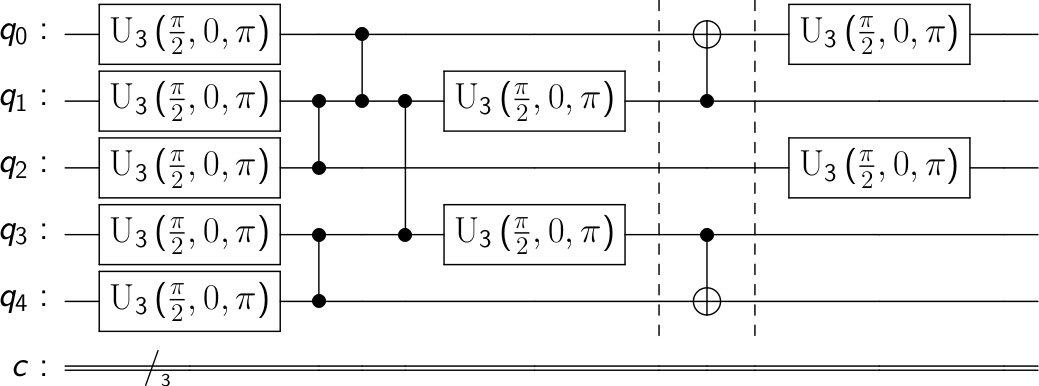

In [264]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_noise_dprz.draw('latex')

In [17]:
t = time.time()

P_amp = tomo(qc=cod(False),
             backend=sim_noise_amp,
             qubits=[0, 1, 2, 3, 4],
            ) 

F_amp = qi.state_fidelity(P_amp[0], qc_sv)
F_amp_mit = qi.state_fidelity(P_amp[2], qc_sv)
print('Fidelidad en el Modelo de Ruido "Amplitud Damping" (s/ corrección): F = {:.5f}'.format(F_amp))
print('                                                   (c/ corrección): F = {:.5f}'.format(F_amp_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_amp[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_amp[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\circuit\quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
C:\Prog

Fidelidad en el Modelo de Ruido "Amplitud Damping" (s/ corrección): F = 0.61607
                                                   (c/ corrección): F = 0.67872


Tiempo de ejecución [minutos] (s/ corrección): t = 0.07963
                              (c/ corrección): t = 0.08986


Tiempo transcurrido [segundos] : t = 20.53481


In [18]:
t = time.time()

P_phs = tomo(qc=cod(False),
             backend=sim_noise_phs,
             qubits=[0, 1, 2, 3, 4],
            ) 

F_phs = qi.state_fidelity(P_phs[0], qc_sv)
F_phs_mit = qi.state_fidelity(P_phs[2], qc_sv)
print('Fidelidad en el Modelo de Ruido "Phase Damping" (s/ corrección): F = {:.5f}'.format(F_phs))
print('                                                (c/ corrección): F = {:.5f}'.format(F_phs_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_phs[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_phs[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Phase Damping" (s/ corrección): F = 0.76966
                                                (c/ corrección): F = 0.76966


Tiempo de ejecución [minutos] (s/ corrección): t = 0.07861
                              (c/ corrección): t = 0.13095


Tiempo transcurrido [segundos] : t = 21.98844


In [19]:
t = time.time()

P_dprz = tomo(qc=cod(False),
             backend=sim_noise_dprz,
             qubits=[0, 1, 2, 3, 4],
            ) 

F_dprz = qi.state_fidelity(P_dprz[0], qc_sv)
F_dprz_mit = qi.state_fidelity(P_dprz[2], qc_sv)
print('Fidelidad en el Modelo de Ruido "Depolarizing" (s/ corrección): F = {:.5f}'.format(F_dprz))
print('                                               (c/ corrección): F = {:.5f}'.format(F_dprz))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_dprz[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_dprz[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Depolarizing" (s/ corrección): F = 0.52481
                                               (c/ corrección): F = 0.52481


Tiempo de ejecución [minutos] (s/ corrección): t = 0.08680
                              (c/ corrección): t = 0.13983


Tiempo transcurrido [segundos] : t = 35.61669


In [20]:
f_amp = fid(qc, tqc_noise_amp, noisy_amp, shots)
f_phs = fid(qc, tqc_noise_phs, noisy_phs, shots)
f_dprz = fid(qc, tqc_noise_dprz, noisy_dprz, shots)

print(f_amp)
print(f_phs)
print(f_dprz)

0.6582621753757227
0.7803955078125001
0.5797119140625001


In [266]:
f_amp_sweep = []
f_phs_sweep = []
f_dprz_sweep = []
p_i = []
n = 1600

for i in range(0, n):
    p_i.append(i/n)
    print(i)
    noisy_amp_sweep = amp_noise(p=i/n)
    noisy_phs_sweep = phs_noise(p=i/n)
    noisy_dprz_sweep = dprz_noise(p=i/n)
    
    tqc_noise_amp_sweep = transpile(qc, AerSimulator(noise_model=noisy_amp))
    tqc_noise_phs_sweep = transpile(qc, AerSimulator(noise_model=noisy_phs))
    tqc_noise_dprz_sweep = transpile(qc, AerSimulator(noise_model=noisy_dprz))

    f_amp_sweep.append(fid(qc, tqc_noise_amp_sweep, noisy_amp_sweep, shots))
    f_phs_sweep.append(fid(qc, tqc_noise_phs_sweep, noisy_phs_sweep, shots))
    f_dprz_sweep.append(fid(qc, tqc_noise_dprz_sweep, noisy_dprz_sweep, shots))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

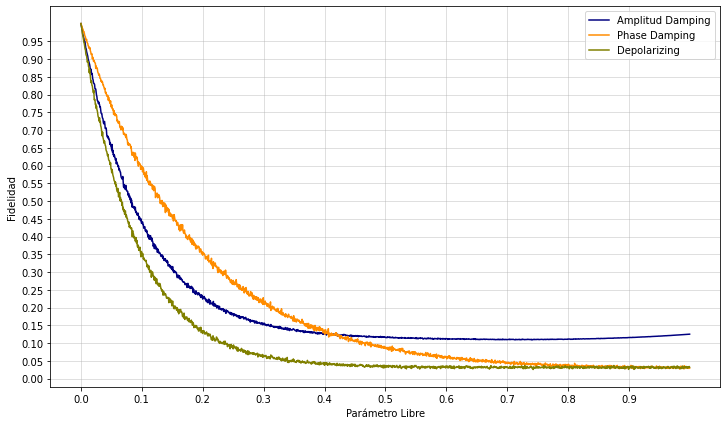

In [267]:
mpl.rcParams["figure.figsize"] = (12,7)
plt.plot(p_i, f_amp_sweep, color='navy', label='Amplitud Damping')
plt.plot(p_i, f_phs_sweep, color='darkorange', label='Phase Damping')
plt.plot(p_i, f_dprz_sweep, color='olive', label='Depolarizing')
plt.xlabel("Parámetro Libre")
plt.ylabel("Fidelidad")
plt.legend(loc='upper right');
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(alpha=0.2)
plt.grid(alpha=0.5)
plt.show()